In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
# import matplotlib as mpl
import argparse
# from read_ggp_run import *
import copy


def mk_missing_dir(directory):
    if not os.path.exists(directory):
        os.mkdir(directory) 
    return directory

def header_lines(filename, until="cell_id"):
    with open(filename,'r') as fin:
        for i, line in enumerate(fin):
            if line.startswith(until):
                return i

def read_final_params(filename):
        parameters_arr = np.genfromtxt(filename, delimiter=',', dtype=str, max_rows=header_lines(filename, until="10")+1)
        param_dict = {}
        for param in parameters_arr[1:]:
            if param[-1] != '':
                param_dict[param[1]] = float(param[-1])
            else:
                param_dict[param[1]] = float(param[3])
        return param_dict


## Gaussian and Correlation Classes

In [409]:
len_mean = 8
len_cov = 36

len_gaussian = len_mean+len_cov

len_gaussian4x4 = 4+10

class Cell:
    def __init__(self, cell_id, parent_id):
        self.parent_id = parent_id
        self.cell_id = cell_id

        self.time = []
        self.number_of_joints = []
        self.line = []
        self.joints = []


# ---------------------------------------------------------------------------------------------------------- #
# Classes to go from the input being chunks of len_mean = 8 + len_cov = 36 to the final correlation function
# ---------------------------------------------------------------------------------------------------------- #
class Gaussian:
    ''' 
    Gaussian (8x8)

    Is constructed from the 8+36 chunk of entires from the input file (strings) and saves the mean and the covariance. 
    In case the entries are empty, mean and covariance are set to None

    Attributes:
        m (np.array((8))): Mean
        C (np.array((8,8))): Covariance

    '''
    def __init__(self, vec, n=8):
        # try:

            # full joint
            if n==8:
                self.m = vec[:8].astype(float)
                cov_vec = vec[8:].astype(float)

                sum_i_9 = [36, 35, 33, 30, 26, 21, 15, 8, 0] #  == [np.sum( np.arange(i,9)) for i in np.arange(1,9)[::1]] + [0]

                # cov_vec[sum_i_9[i]: sum_i_9[i-1] ] Equivalent to cov_vec[np.sum( np.arange(i+1,9) ): np.sum( np.arange(i,9))]
                # Also the concatenation with 0s is faster than np.pad
                c = np.array( [ np.concatenate( ([0] *(8-i) , cov_vec[sum_i_9[i]: sum_i_9[i-1] ] ) ) for i in np.arange(1,9)[::-1]])
                self.C = c + np.tril(c.T, -1) 

            # "joint" from full marginal
            elif n==4:
                m = vec[:4].astype(float)
                self.m = np.hstack((m,m))

                cov_vec = vec[4:].astype(float)
                sum_i_5 = [10, 9, 7, 4, 0] 
                c = np.array( [ np.concatenate( ([0] *(4-i) , cov_vec[sum_i_5[i]: sum_i_5[i-1] ] ) ) for i in np.arange(1,5)[::-1]])
                C = c + np.tril(c.T, -1) 
                self.C = np.vstack((np.hstack((C, C)), np.hstack((C,C))))
            
            # aprrox. joint from marginal
            elif n==2:
                marginal1 = vec[:14].astype(float)
                marginal2 = vec[14:28].astype(float)

                self.m = np.hstack(( marginal1[:4], marginal2[:4]))
                sum_i_5 = [10, 9, 7, 4, 0] 

                cov_vec1 = marginal1[4:]
                c1 = np.array( [ np.concatenate( ([0] *(4-i) , cov_vec1[sum_i_5[i]: sum_i_5[i-1] ] ) ) for i in np.arange(1,5)[::-1]])
                C1 = c1 + np.tril(c1.T, -1) 

                cov_vec2 = marginal2[4:]
                c2 = np.array( [ np.concatenate( ([0] *(4-i) , cov_vec2[sum_i_5[i]: sum_i_5[i-1] ] ) ) for i in np.arange(1,5)[::-1]])
                C2 = c2 + np.tril(c2.T, -1) 

                zeros = np.zeros((4,4))
                self.C = np.vstack(( np.hstack((C1, zeros))  , np.hstack((zeros,C2)) ))

        # except:
        #     self.m = None
        #     self.C = None


def log_likelihood_function(V_yy,V_yx,V_xx, sigma_y, sigma_x, r, n):
    """log likelihood function 

    Args:
        V_yy (double): second moment over y
        V_yx (double): second moment over y and x
        V_xx (double): second moment over x
        sigma_y (double): std of gaussian y is drawn from
        sigma_x (double): std of gaussian x is drawn from
        r (np.array()): correlation [0,1]
        n (int): number of pairs

    Returns:
        np.array(): log likelihood as a function of r
    """
    return -n/2*(np.log(1-r**2) + (V_yy  - 2*r*sigma_y/sigma_x*V_yx + r**2*(sigma_y/sigma_x)**2*V_xx)/(sigma_y**2 * (1-r**2)) ) 


def log_likelihood_error(V_yy,V_yx,V_xx, sigma_y, sigma_x, r, n):
    """Error bar on mle of r

    Args:
        V_yy (double): second moment over y
        V_yx (double): second moment over y and x
        V_xx (double): second moment over x
        sigma_y (double): std of gaussian y is drawn from
        sigma_x (double): std of gaussian x is drawn from
        r (double): correlation [0,1]
        n (int): number of pairs

    Returns:
        double: error bar on r
    """
    log_term = n * (1 + r**2)/(1 - r**2)**2 
    v_term = -n/2 *1/sigma_y**2  * ( \
            (2*(sigma_y/sigma_x)**2*V_xx) / (1-r**2) +
            (8*r*(r*(sigma_y/sigma_x)**2*V_xx - sigma_y/sigma_x * V_yx)) / (1-r**2)**2 + \
            ( (8*r**2)/(1-r**2)**3  + 2/((1-r**2)**2) ) * \
            (V_yy - 2*r* sigma_y/sigma_x * V_yx + r**2*(sigma_y/sigma_x)**2*V_xx))
    ddldrr = log_term + v_term
    if -1/ddldrr>0:
        return np.sqrt(-1/ddldrr)
    else:
        if np.abs(-1/ddldrr)>1e-10:
            print(-1/ddldrr)
        return 0

        
class Correlation:
    '''
    Calculates the correlation of a given dt

    Adds up the means (m) <z_n> as well as the two point means (mm) <z_n, z_m> = <z_n><z_m> + C, 
    while counting the number of joints (n)

    Attributes:
        dt (float): Time lag
        n (int): Number of joints
        m (np.array((8))): Sum of one point means
        V_xy (np.array((8,8))): Sum of two point means
        cov (np.array((8,8))): Covariance matrix (None when initialized)
        corr_naive (np.array((8,8))): Naive correlation matrix, ie the normalized covariance (None when initialized)
        corr_mle (np.array((8,8))): MLE correlation matrix, ie the normalized covariance (None when initialized)
        corr_mle_err (np.array((8,8))): Error of MLE correlation matrix, ie the normalized covariance (None when initialized)


    '''
    def __init__(self, dt = 0):
        self.dt = dt
        self.n = 0

        self.mm = np.zeros((8,8))
        self.m = np.zeros((8))
        
        # Those will be set in average and normalize, resprectively 
        self.cov = None
        
        self.corr_naive = None

        self.corr_mle = None
        self.corr_mle_err = None


    def add(self, joint, naive=False):
        """add (sum) posterior to current sum of moments: mm = <xy> and m = <x>

        Args:
            joint (Gaussian): posterior joint to be added 
        """
        self.n += 1
        self.m += joint.m
        if naive:
            self.mm += joint.m * joint.m[:,np.newaxis]
        else:
            self.mm += joint.m * joint.m[:,np.newaxis] + joint.C
        # Equivalent to:
        # for i in range(8): for j in range(8): self.mm[i,j] += joint.m[i] * joint.m[j] + joint.C[i,j]



    # the following functions are simple implementations but they is not often run
    def average(self):
        """calculated covariance <xy> - <x><y>, sets cov
        """
        self.cov = np.zeros((8,8))
        for i in range(8):
                for j in range(8):
                    self.cov[i,j] = self.mm[i,j]/self.n -  self.m[i]/self.n * self.m[j]/self.n


    def naive(self):
        """naive calculation of normalized correlation, sets corr_naive
        """
        self.corr_naive = np.zeros((8,8))
        if self.n>0:
            for i in range(8):
                for j in range(8):
                    self.corr_naive[i,j] = self.cov[i,j] / np.sqrt(self.cov[i,i] * self.cov[j,j])


    def mle(self, covarince0):
        """MLE of the correlation with error bars, sets corr_mle and corr_mle_err

        Args:
            covarince0 (np.array((8,8))): covariance matrix for dt=0 
                                            i.e. diagonal is variance estiamte of the 
                                            underlying distr. x and y are drawn from
        """
        self.corr_mle = np.zeros((8,8))
        self.corr_mle_err = np.zeros((8,8))

        r = np.linspace(-1+1e-8,1-1e-8,10000)

        if self.n>0:
            for i in range(8):
                for j in range(8):
                    V_yx = self.cov[j,i] # cov is symmetric
                    V_xx = self.cov[i,i]
                    V_yy = self.cov[j,j]
                    sigma_y = np.sqrt(covarince0[j,j])
                    sigma_x = np.sqrt(covarince0[i,i])

                    ll = log_likelihood_function(V_yy, V_yx, V_xx, 
                                                sigma_y, sigma_x, r, self.n)
                    r_max = r[np.argmax(ll)]
                    err = log_likelihood_error(V_yy,V_yx,V_xx, sigma_y, sigma_x, r_max, self.n)

                    self.corr_mle[i,j] = r_max
                    self.corr_mle_err[i,j] = err
        




### Helper functions for tree structure

In [410]:

def cell_paths(start_cell, cell_list):
    path = [start_cell]
    cell = cell_list[start_cell]
    while cell in cell_list:
        path.append(cell)
        cell = cell_list[cell]
    return path

def paths2matrix(paths, cells):
    lookup = np.zeros(( len(cells),len(cells) ))
    for i, c1 in enumerate(cells):
        for j, c2 in enumerate(cells):
            for path in paths:
                if c1 in path and c2 in path:
                    lookup[i,j] = 1
    return pd.DataFrame(lookup, cells, cells)

def cell_lineage_lookup(cells, parents):
    cell_parent = {}
    parent_cell = {}

    for i, cell in enumerate(cells):
        cell_parent[cell] = parents[i]

    paths = []
    for c in cells:
        if c not in parents:
            paths.append(cell_paths(c, cell_parent))
    return paths2matrix(paths, cells)


# cells = ["c", "d", "e", "a", "b",  "f"]

# parents = ["0", "b", "b", "0", "a",  "c"]

# plt.imshow(cell_lineage_lookup(cells, parents))
# m = cell_lineage_lookup(cells, parents)
# m.loc["a", "d"]

## Read joint file

In [402]:
def files2correlation_function(joint_file, prediction_file, dts, tol, naive_exp=False, only_marg=False): 
    """reads joint_file and prediction_file as input and calculates the correlation function

    Args:
        joint_file (str): [description]
        prediction_file (str): [description]
        dts (np.array()): dt values over which the correlatio will be calculated
        tol (double): tolerance of dt, i.e. joint posterior with dt' will be used for C(dt) if |dt'-dt|<dt;
                        should be much smaller that any increment of dts

    Returns:
        list(Correlation): list of Correlation class instances that contain all needed statistics
    """
    # Variables that will be returned
    correlations = [Correlation(dt=dt) for dt in dts]

    # initialize a few variable 
    last_cell = ""
    count_cells = 0 
    skip = True
    
    cell_ids = []
    parent_ids = []

    marginals = []
    cell_tag = []

    ### read the prediction_file to get statistics for C(dt=0) ###
    with open(prediction_file,'r') as fin:
        for _, line in enumerate(fin):
            if not skip:
                
                line_splitted = line.strip('\n').split(',')
                cell_id = line_splitted[0]
                time = line_splitted[2]

                marginals.append(line_splitted[5:])
                cell_tag.append((line_splitted[0], time))
                joint = Gaussian(np.array(line_splitted[5:]),n=4)
                
                idx = np.argwhere(np.isclose(dts, 0, atol=tol)) # in case 0 is not the dt this is needed
                if len(idx)>0:
                    correlations[idx[0,0]].add(joint, naive=naive_exp)

                if cell_id != last_cell:
                    cell_ids.append(cell_id)
                    parent_ids.append( line_splitted[1])

                last_cell = cell_id

            if line.startswith('cell_id'):
                skip = False    

    cell_lineage_lookup_table = cell_lineage_lookup(cell_ids, parent_ids)
    time_point_cols = []
    cell_id_cols = []

    last_cell = ""
    skip = True
    i=0
    ### read the joint_file to get statistics for C(dt>0)  ###
    with open(joint_file,'r') as fin:
        for _, line in enumerate(fin):
            if not skip:
                line_splitted = line.strip('\n').split(',')
                cell_id_row = line_splitted[0]
                time_row = float(line_splitted[2])
                chunks =  np.reshape(line_splitted[3:], (-1,len_gaussian))
                joints_vecs = [Gaussian(c) if c[0]!='' else None for c in chunks] # eg [G, None, G, G, None]
                for j, joint in enumerate(joints_vecs):
                    time_plus_dt = time_point_cols[j] 
                    if joint != None and not only_marg:                        
                        idx = np.argwhere(np.isclose(dts, time_plus_dt - time_row, atol=tol))
                        if len(idx)>0:
                            correlations[idx[0,0]].add(joint, naive=naive_exp)
                    else:
                        if cell_lineage_lookup_table.loc[cell_id_row, cell_id_cols[j]] and j>i:
                            idx = np.argwhere(np.isclose(dts, time_plus_dt - time_row, atol=tol))  
                            if len(idx)>0:
                                joint = Gaussian(np.array(marginals[j] + marginals[i]), n=2)
                                correlations[idx[0,0]].add(joint, naive=naive_exp)
                        else:
                            pass
                        
                i += 1            
                if cell_id_row != last_cell:
                    # print("\rNumber of cells processed: ", count_cells, end='')  
                    count_cells += 1

                last_cell = cell_id_row

            if line.startswith('cell_id'):
                skip = False    
                line_splitted = line.strip('\n').split(',')[3:]
                for entry in line_splitted:
                    if entry != '':
                        cell_id_cols.append(entry.split('_')[0])
                        time_point_cols.append(float(entry.split('_')[1]))
                        
    # finally calculate cov, corr_naive, corr_mle, corr_mle_error
    for i, dt in enumerate(dts):
        correlations[i].average()
        correlations[i].naive()
        correlations[i].mle(correlations[0].cov)

    return correlations



## Plotting

In [403]:
def tree_correlation_plot(correlations, x, y, plot_file=None, title=None, param_dict=None, min_joint_number=10):
    mapping = {z:i for i, z in enumerate(["x(t+dt)", "g(t+dt)", "l(t+dt)", "q(t+dt)", "x(t)", "g(t)", "l(t)", "q(t)"])}

    rs = []
    errs = []

    dts = []
    corr_naive = []

    for i, corr in enumerate(correlations):
        if corr.n>min_joint_number:
            dts.append(corr.dt)

            rs.append(corr.corr_mle[mapping[x],mapping[y]])
            errs.append(corr.corr_mle_err[mapping[x],mapping[y]])

            corr_naive.append(corr.corr_naive[mapping[x],mapping[y]])

    # =========== plot =========== #
    # decide if exponential will be plotted
    gamma = None
    if param_dict!=None:
        if x[0] == "l" and y[0] == "l":
            gamma = param_dict["gamma_lambda"]
        elif x[0] == "q" and y[0] == "q":
            gamma = param_dict["gamma_q"]

    # prepare axes depending on whether exponential is plotted
    if gamma!=None:
        fig, _ = plt.subplots(figsize=(8,8))
        ax0 = plt.subplot2grid((2, 1), (0, 0)) # the figure has 3 row, 2 columns, and this plot is the first plot. 
        ax1 = plt.subplot2grid((2, 1), (1, 0), sharex=ax0)
        axs = [ax0, ax1]
    else:
        fig, _ = plt.subplots(figsize=(8,4))

        ax0 = plt.subplot2grid((1,1), (0, 0)) # the figure has 3 row, 2 columns, and this plot is the first plot. 
        axs = [ax0]

    for ax in axs:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # set the x-spine
        ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        ax.spines['right'].set_color('none')
        ax.yaxis.tick_left()
    

    # add top x axis
    secax0 = ax0.secondary_xaxis('top', functions=(lambda x:  x/(np.log(2)/param_dict["mean_lambda"]), 
                                                    lambda x: x*(np.log(2)/param_dict["mean_lambda"]) ))
    secax0.set_xlabel('dts (cell cycle)')

    if title!=None:
        ax0.set_title(title,fontweight="bold")
    dts = np.array(dts).astype(float)
    if param_dict!=None:
        ax0.axvline(np.log(2)/param_dict["mean_lambda"], color="grey", ls='--')

    ax0.errorbar(dts, rs, yerr=errs, label=r"$\langle {:s}, {:s}\rangle$".format(x,y), lw=2, color="tab:blue")
    ax0.plot(dts, corr_naive, label=r"naive $\langle {:s}, {:s}\rangle$".format(x,y), lw=2, color="tab:green")

    ax0.set_ylabel("correlation")
    ax0.set_ylim([-0.3,1.1])
    ax0.legend()
    
    if gamma!=None:
        secax1 = ax1.secondary_xaxis('top', functions=(lambda x:  x/(np.log(2)/param_dict["mean_lambda"]), 
                                                    lambda x: x*(np.log(2)/param_dict["mean_lambda"]) ))

        ax0.plot(dts, np.exp(-dts*gamma), label="exponential", color="darkgrey")
        ax1.errorbar(dts, rs-np.exp(-dts*gamma), yerr=errs, label=r"$\langle {:s}, {:s}\rangle$".format(x,y), lw=2, color="tab:blue")
        ax1.plot(dts, corr_naive-np.exp(-dts*gamma), label=r"naive $\langle {:s}, {:s}\rangle$".format(x,y), lw=2, color="tab:green")

        ax1.plot(dts, dts*0, color="darkgrey")
        ax1.axvline(np.log(2)/param_dict["mean_lambda"], color="grey", ls='--')

        ax1.set_ylabel("deviation from exponential")
        ax1.set_ylim([-0.5, 0.5])
        # ax1.set_xlim([0, 100])

        ax1.legend()
        
        ax1.set_xlabel("dt (min)")

    else:
        ax0.plot(dts, dts*0, color="darkgrey")
        ax0.set_xlabel("dt (min)")

    fig.tight_layout(h_pad=4)
    if plot_file != None:
        plot_output = plot_file.format(y[0], x[0])
        print("Saved in", plot_output)
        fig.savefig(plot_output, dpi=300, facecolor="white")
    plt.show()



In [404]:
def tree_correlation_plot_list(correlations_list, x, y, plot_file=None, labels=[], param_dict_list=[], min_joint_number=10):
    mapping = {z:i for i, z in enumerate(["x(t+dt)", "g(t+dt)", "l(t+dt)", "q(t+dt)", "x(t)", "g(t)", "l(t)", "q(t)"])}
    import matplotlib.colors as mcolors
    from matplotlib import cm

    norm = mcolors.Normalize(vmin=0, vmax=9.9)

    colors_sets = {}
    for i, l in enumerate(labels):
        colors_sets[l] = cm.tab10(norm(i)) 

    # =========== figure =========== #
    fig, _ = plt.subplots(figsize=(8,4))
    ax0 = plt.subplot2grid((1,1), (0, 0)) 
    axs = [ax0]

    for ax in axs:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # set the x-spine
        ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        ax.spines['right'].set_color('none')
        ax.yaxis.tick_left()


    # =========== plot =========== #
    # decide if exponential will be plotted
    for correlations, param_dict, label in zip(correlations_list, param_dict_list, labels):
        gamma = None
        if x[0] == "l" and y[0] == "l":
            gamma = param_dict["gamma_lambda"]
        elif x[0] == "q" and y[0] == "q":
            gamma = param_dict["gamma_q"]

        if param_dict!=None:
            ax0.axvline(np.log(2)/param_dict["mean_lambda"], color=colors_sets[label], alpha=0.5)

        # =========== correlation =========== #
        rs = []
        errs = []

        dts = []
        corr_naive = []

        for i, corr in enumerate(correlations):
            if corr.n>min_joint_number:
                dts.append(corr.dt)

                rs.append(corr.corr_mle[mapping[x],mapping[y]])
                errs.append(corr.corr_mle_err[mapping[x],mapping[y]])

                corr_naive.append(corr.corr_naive[mapping[x],mapping[y]])

        dts = np.array(dts).astype(float)

        ax0.errorbar(dts, rs, yerr=errs, lw=2, color=colors_sets[label], label=label)
        
        if gamma!=None:
            ax0.plot(dts, np.exp(-dts*gamma), ls='--', color=colors_sets[label], alpha=0.6)
        else:
            ax0.plot(dts, dts*0, color=colors_sets[label])


    # ===== layout ===== #
    ax0.set_ylabel(r"$\langle {:s}, {:s}\rangle$".format(x,y))
    ax0.set_ylim([-0.3,1.1])
    ax0.legend()
    ax0.set_xlabel("dt (min)")
    
    fig.tight_layout(h_pad=4)
    if plot_file != None:
        plot_output = plot_file.format(y[0], x[0])
        print("Saved in", plot_output)
        fig.savefig(plot_output, dpi=300, facecolor="white")
    else:
        plt.show()




## Testing

/Users/bjoern/mother_machine/data_3.0/ac_tree_n3_sizer/ac_tree_n3_sizer_out/ac_tree_n3_sizer_f012345678910_b_prediction.csv


ipykernel_launcher:189: RuntimeWarning: invalid value encountered in double_scalars


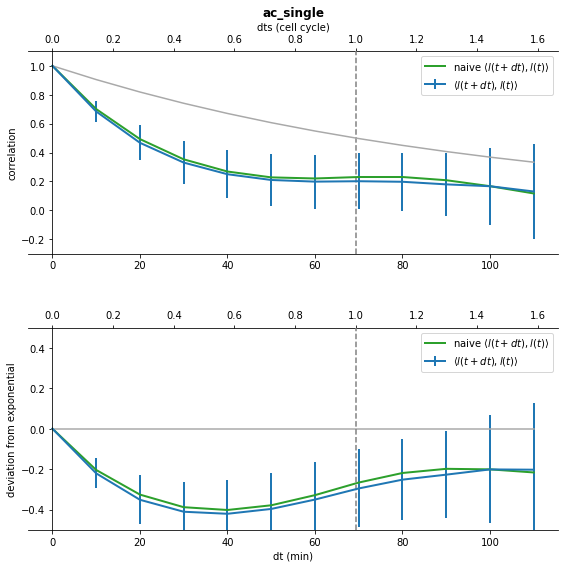

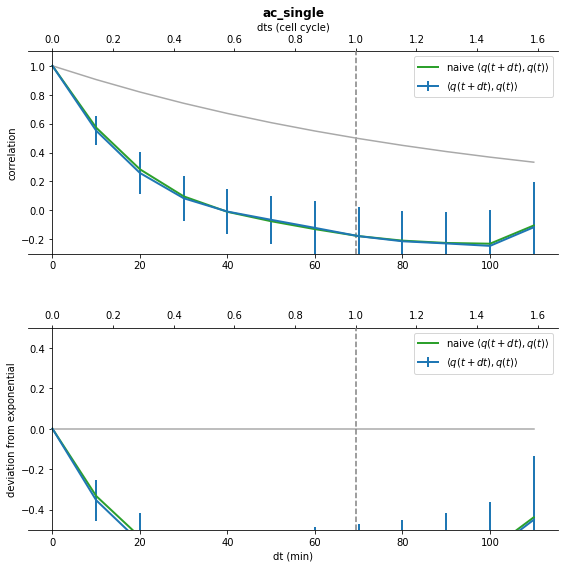

In [405]:
joint_filenames =['/Users/bjoern/mother_machine/data_3.0/ac_tree_n3_sizer/ac_tree_n3_sizer_out/ac_tree_n3_sizer_f012345678910_b_joints.csv']
corrs = []
dts=[10]

for jf, dt in zip(joint_filenames, dts):
    pf = jf.replace("joints", "prediction")
    print(pf)
    corr = files2correlation_function(jf, pf, np.arange(0, 500, dt), 0.3)
    corrs.append(corr)

    tree_correlation_plot(corr, "l(t+dt)", "l(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))
    tree_correlation_plot(corr, "q(t+dt)", "q(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))


/Users/bjoern/mother_machine/data_3.0/ac_tree_n3_sizer/ac_tree_n3_sizer_out/ac_tree_n3_sizer_f012345678910_b_prediction.csv


ipykernel_launcher:189: RuntimeWarning: invalid value encountered in double_scalars


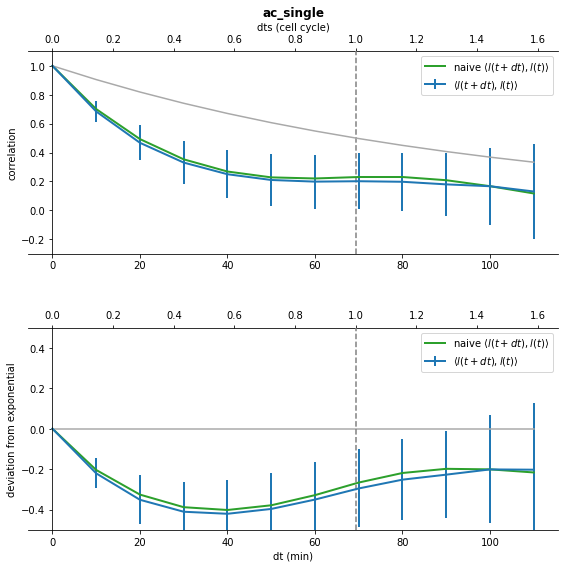

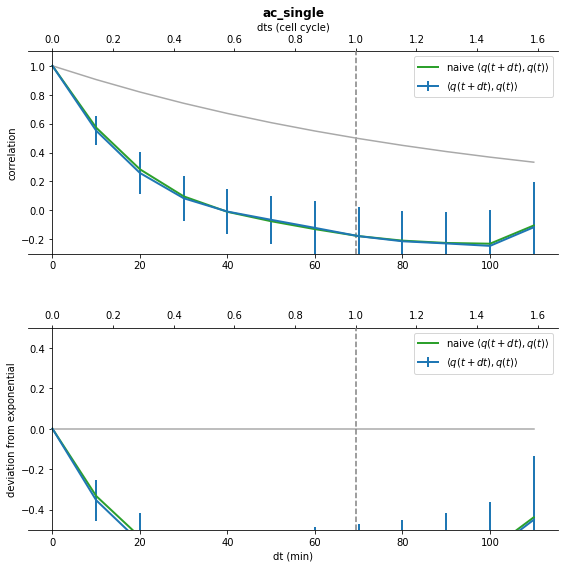

In [406]:
joint_filenames =['/Users/bjoern/mother_machine/data_3.0/ac_tree_n3_sizer/ac_tree_n3_sizer_out/ac_tree_n3_sizer_f012345678910_b_joints.csv']
corrs = []
dts=[10]

for jf, dt in zip(joint_filenames, dts):
    pf = jf.replace("joints", "prediction")
    print(pf)
    corr = files2correlation_function(jf, pf, np.arange(0, 500, dt), 0.3)
    corrs.append(corr)

    tree_correlation_plot(corr, "l(t+dt)", "l(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))
    tree_correlation_plot(corr, "q(t+dt)", "q(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))


/Users/bjoern/mother_machine/data_4.0/acetate_hi1_test/acetate_hi1_out/acetate_hi1_f01234578910_b_prediction.csv
('20200812.25.b.12.12.1.0', '731.25') 20200812.25.b.12.12.1.0 731.25 ('20200812.25.b.12.22.1.0', '1293.75') 20200812.25.b.12.22.1.0 1293.75 562.5
('20200812.25.b.12.12.1.0', '731.25') 20200812.25.b.12.12.1.0 731.25 ('20200812.25.b.12.22.1.0', '1312.5') 20200812.25.b.12.22.1.0 1312.5 581.25
('20200812.25.b.12.12.1.0', '731.25') 20200812.25.b.12.12.1.0 731.25 ('20200812.25.b.12.22.1.0', '1331.25') 20200812.25.b.12.22.1.0 1331.25 600.0
('20200812.25.b.12.12.1.0', '731.25') 20200812.25.b.12.12.1.0 731.25 ('20200812.25.b.12.22.1.0', '1350') 20200812.25.b.12.22.1.0 1350.0 618.75
('20200812.25.b.12.12.1.0', '731.25') 20200812.25.b.12.12.1.0 731.25 ('20200812.25.b.12.22.1.0', '1368.75') 20200812.25.b.12.22.1.0 1368.75 637.5
('20200812.25.b.12.12.1.0', '731.25') 20200812.25.b.12.12.1.0 731.25 ('20200812.25.b.12.22.1.0', '1387.5') 20200812.25.b.12.22.1.0 1387.5 656.25
('20200812.25.b.

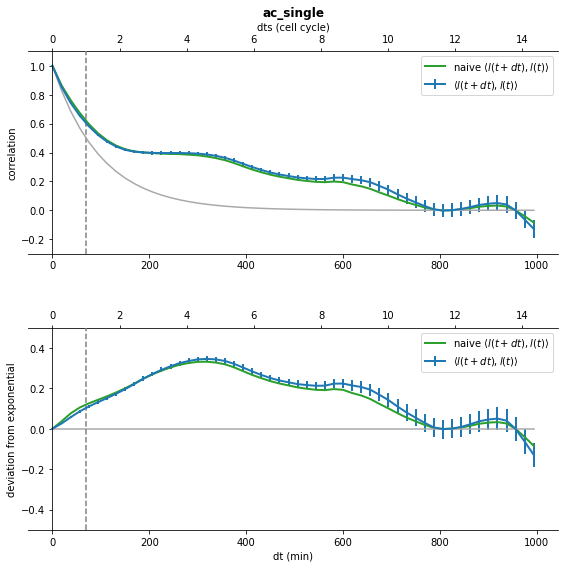

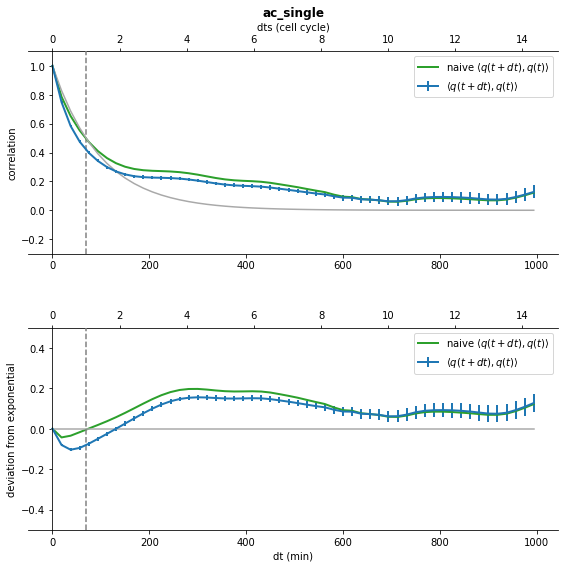

In [408]:
joint_filenames =['/Users/bjoern/mother_machine/data_4.0/acetate_hi1_test/acetate_hi1_out/acetate_hi1_f01234578910_b_joints.csv']

corrs = []
dts=[18.75]

for jf, dt in zip(joint_filenames, dts):
    pf = jf.replace("joints", "prediction")
    print(pf)
    corr = files2correlation_function(jf, pf, np.arange(0, 1000, dt), 0.3)
    corrs.append(corr)

    tree_correlation_plot(corr, "l(t+dt)", "l(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))
    tree_correlation_plot(corr, "q(t+dt)", "q(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))


In [ ]:

param_dict_list=[]
labels = [] 

for filename in joint_filenames:
    param_dict_list.append(read_final_params(filename))
    labels.append(filename.split('/')[-1].split("_")[0] + "_" + filename.split('/')[-1].split("_")[1])
tree_correlation_plot_list(corrs, "l(t+dt)", "l(t)", plot_file=None, labels=labels, param_dict_list=param_dict_list, min_joint_number=10)


In [ ]:
joint_filenames =['/Users/bjoern/mother_machine/data_3.0/ac_single_lineage_n500_sizer/ac_single_lineage_n500_sizer_0/ac_single_lineage_n500_sizer_0_out/ac_single_lineage_n500_sizer_0_f012345678910_b_joints.csv']


corrs = []
dts=[3, 3, 3, 3]


for jf, dt in zip(joint_filenames, dts):
    pf = jf.replace("joints", "prediction")
    corr = files2correlation_function(jf, pf, np.arange(0, 500, dt), 0.3)
    corrs.append(corr)

In [ ]:
for filename, dt, corr in zip(joint_filenames, dts, corrs):
    data_set = filename.split("/")[-1].split("_")[0] + '_' + filename.split("/")[-1].split("_")[1]
    plot_file = None

    tree_correlation_plot(corr, "l(t+dt)", "l(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))
    tree_correlation_plot(corr, "q(t+dt)", "q(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))

    tree_correlation_plot(corr, "l(t+dt)", "q(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))
    tree_correlation_plot(corr, "q(t+dt)", "l(t)", plot_file=plot_file, title=data_set, param_dict=read_final_params(filename))
    # break
